In [1]:
from models.utils import generate_backbone
import torch.nn as nn
from collections import OrderedDict

In [2]:
net, _ = generate_backbone(type='inflated')

In [3]:
# drop last two layers
del net.fc
del net.avgpool

In [4]:
mdict = OrderedDict(dict(net.named_children()))

In [5]:
m_fc_detached = nn.Sequential(mdict)
m_fc_detached

Sequential(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): 

In [6]:
import cv2
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as TF
import torch.nn as nn
import torchvision.models as models
from collections import OrderedDict
from torchvision.utils import make_grid
from scipy.ndimage import zoom

In [7]:
cap = cv2.VideoCapture('/data/FallDownData/MulticamFD/video/fall/chute01-cam1-s03.avi')
# cap = cv2.VideoCapture('/data/FallDownData/URFD/video/fall/fall-01-cam1-rgb.avi')

In [8]:
frames = []
while True:
    ret, frame = cap.read()
    if not ret: break
    frame = cv2.resize(frame, (112, 112))
    frames.append(Image.fromarray(frame))

In [9]:
trans = TF.Lambda(lambda crops: torch.stack([TF.ToTensor()(crop) for crop in crops]))

In [10]:
frame_tensor = trans(frames[:16]).permute(1, 0, 2, 3)[None, ...]
frame_tensor.shape

torch.Size([1, 3, 16, 112, 112])

In [11]:
conv_out = m_fc_detached(frame_tensor).mean(1)[0].data
conv_out.shape

torch.Size([2, 7, 7])

In [12]:
sample_duration = 16
sample_size = 112

In [13]:
# upsample grad_cam
temporal_ratio = sample_duration / conv_out.shape[0]
spatial_ratio = sample_size / conv_out.shape[1]

conv_out = zoom(conv_out, (temporal_ratio,
                           spatial_ratio, spatial_ratio))

In [14]:
img_tensor = frame_tensor[0].data.numpy()
activation_result = conv_out
print('img_size : ', img_tensor.shape, 'activation_size : ', activation_result.shape)

img_size :  (3, 16, 112, 112) activation_size :  (16, 112, 112)


In [15]:
overlay_seq = []

for t in range(img_tensor.shape[1]):
    img_ = np.uint8(255*img_tensor[:, t]).transpose(1,2,0)
    heatmap_ = np.uint8(255*activation_result[t])
    heatmap_ = cv2.cvtColor(cv2.applyColorMap(heatmap_, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    frame = np.uint8(heatmap_*0.2 + img_*0.8)
    overlay_seq.append(frame)

In [16]:
feats_grid = make_grid(torch.tensor(overlay_seq).permute(0, 3, 1, 2))

In [17]:
import matplotlib.pyplot as plt
plt.ion()

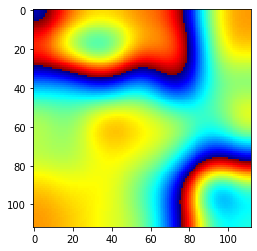

In [18]:
plt.imshow(cv2.cvtColor(heatmap_, cv2.COLOR_BGR2RGB))

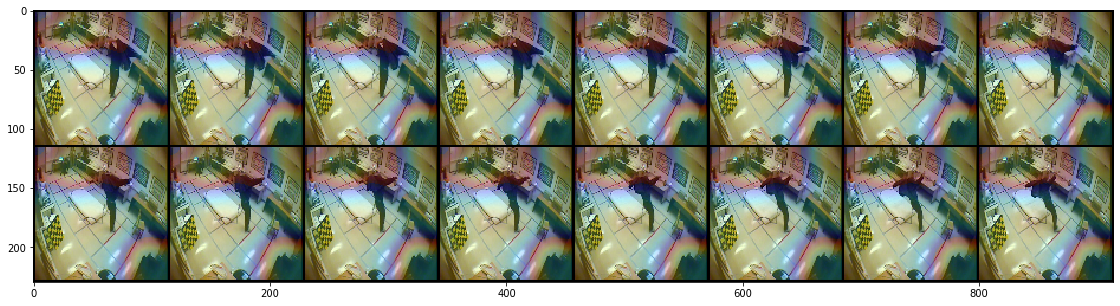

In [19]:
plt.figure(figsize=(20,5))
plt.imshow(cv2.cvtColor(feats_grid.permute(1,2,0).numpy(), cv2.COLOR_BGR2RGB))

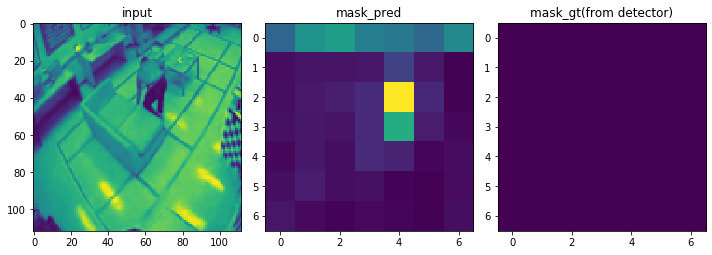

In [46]:
mask_pred = np.array(Image.open('mask_pred.tiff'))
mask_gt = np.array(Image.open('mask_gt.tiff') )
image = np.array(Image.open('input_frame.tiff') )

images = {
    'input' : image,
    'mask_pred' : mask_pred,
    'mask_gt(from detector)': mask_gt
}
plt.figure(figsize=(10,10))
for i,(title, im) in enumerate(images.items()):
    ax = plt.subplot(1,3,i+1)
    ax.imshow(im)
    ax.set_title(title)
    

plt.tight_layout()
plt.show()

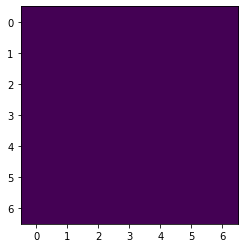

In [31]:
im = Image.open('mask_gt.tiff') 
imarray = np.array(im) 
plt.imshow(imarray)

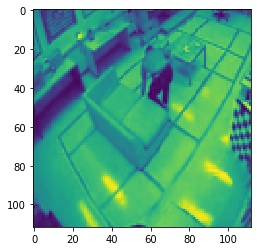

In [32]:
im = Image.open('input_frame.tiff') 
imarray = np.array(im) 
plt.imshow(imarray)

In [7]:
import torchvision
import torch
import matplotlib.pyplot as plt

In [10]:
x = torch.randn(3,64,21,35)
torchvision.transforms.functional.to_pil_image(x[0, 0])

In [41]:
rois = torchvision.ops.roi_pool(x, boxes=[torch.tensor([[0.,0.,10.,10.], [5.0, 3.0, 9.0, 7.0]]),
                                          torch.tensor([[5.0, 9.5, 100.0, 99.9]])
                                         ], output_size=(7,7))

In [42]:
rois.shape

torch.Size([3, 64, 7, 7])

In [25]:
rois[0,0]

tensor([[1.8071, 2.9594, 0.4811, 0.9634, 0.9634, 0.7503, 0.7503],
        [1.8071, 1.8071, 0.8116, 0.9634, 0.9634, 0.7503, 0.7503],
        [0.5205, 1.5020, 1.9734, 1.9734, 1.3637, 1.0718, 1.1847],
        [1.4765, 1.5020, 1.9734, 1.9734, 1.3637, 1.6787, 1.1847],
        [1.4765, 1.4765, 1.4054, 3.1698, 1.0651, 0.8908, 0.8908],
        [0.7611, 1.2424, 1.2424, 3.1698, 1.8070, 2.7147, 2.7147],
        [1.5682, 1.2424, 1.6163, 1.7691, 1.8070, 2.7147, 2.7147]])

In [38]:
x[0, 0, 0:3, 0:5].max()

tensor(2.9594)